# Import libraries and dataset

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

In [263]:
df = pd.read_csv(r"C:\Users\Cris\Documents\Repos\TitanicML\titanic_train.csv")

# Exploratory Data Analysis

## Initial exploration

In [264]:
# Check details of our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that our dataframe has 11 columns with 891 entries, with different data types such as integers, floats, and objects. We can visualize the first 5 entries of our dataset:

In [265]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It seems like our *object* data types are string-like. Now we can begin cleaning our dataset.

## Missing Values

In [266]:
# Obtain dataframe's null values in boolean, and add the 1s to count total number of missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It appears that there are 2 missing values for Embarked, 177 missing values for Age, and an important 687 null values in the Cabin column. We shall deal with these situations the following ways per column.

### Embarked

In [267]:
# View the datapoints where Embarked has missing values
df[df.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Since there are only two missing rows for this category, it seems reasonable to simply drop these values, since the loss of information would be negligible. However, we could predict the two missing values with a simulation based on the probability of embarking on each port.

In [268]:
# Obtain the number of ocurrances of each port
embarked_probs = df.Embarked[df.Embarked.notna()].value_counts()

# Display the distribution of occurrances as percent of total occurrances
print(embarked_probs/embarked_probs.sum())

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64


So, given the distribution of port occurrence, one shall assign the probability of embarking in a given port with those proportions. Therefore the simulation yields

In [269]:
import random

# Make a simulation using random.choices with the weights of the occurrances; simulate 2 instances.
embarked_simulation = random.choices(population=embarked_probs.index.to_list(), weights=embarked_probs.to_list(), k=2)
print(embarked_simulation)

['S', 'S']


In [270]:
# Replace null values with the results of the probabilistic simulation
# We have to transform the Python list to Pandas Series with the correct index to replace the null values of the original dataframe correctly
df.Embarked.fillna(pd.Series(embarked_simulation, index=df[df.Embarked.isna()].index), inplace=True)

In [271]:
# View the datapoints with their new Embarked values
df[df.Cabin == "B28"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


### Cabin

Since there are 687 missing values for cabin, one can say that it would be too costly to remove these datapoints because of one missing value. Therefore, we will assign the value of "Unknown" Cabin as a category U. This will later be useful for feature engineering and determining the relevance of cabin on the probability of survival.

In [272]:
df.Cabin.fillna("U", inplace=True)

In [273]:
df.Cabin.isna().sum()

0

In [274]:
df.Cabin.value_counts().head(8)

U              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
D                3
F33              3
E101             3
Name: Cabin, dtype: int64

This reveals that the cabin data column is kind of weird, and it presents very irregular formatting. This might become an issue for the ML model, and we'll figure out how to deal with these irregularities later in this notebook

### Age

In [275]:
df.Age.isna().sum()

177

In [276]:
df[df.Age.isna()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,U,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,U,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,U,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,U,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,U,Q


In [277]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Even though it seems that Age is data missing not at random (MNAR), given the difficulty of the imputation methods for these types of cases, it's reasonable to extract a random sample from the already existing sample of age.

In [278]:
# Obtain a random sample from the existing age distribution
age_sample = df.Age[df.Age.notna()].sample(df.Age.isna().sum())

# Replace the null values by transforming the resulting sample into list in order to assign the correct index for replacement (fillna() method)
df.Age.fillna(pd.Series(age_sample.to_list(), index=df.Age[df.Age.isna()].index), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Feature visualization

### Fare

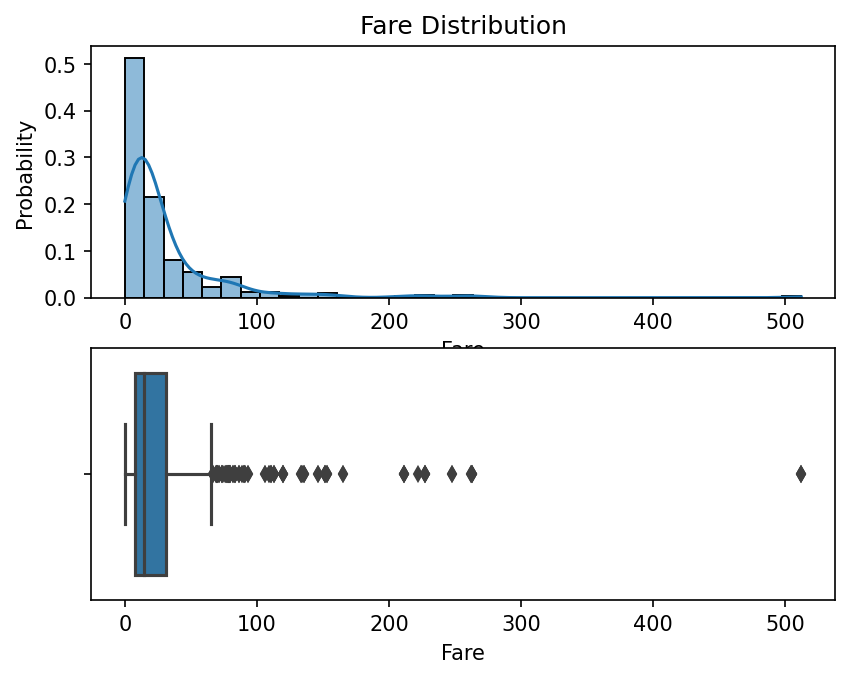

In [279]:
fig, axes = plt.subplots(2,1)

sns.histplot(data=df, x="Fare", kde=True, stat="probability", bins=35, ax = axes[0])
axes[0].set_title("Fare Distribution")

sns.boxplot(data=df, x="Fare", ax=axes[1])

plt.show()

In [280]:
def remove_outliers(series, n):
    # n - determine magnitude of outlier (1.5 - normal, 3 - extreme)
    q3, q1 = series.quantile([0.75, 0.25])
    iqr = q3 - q1
    print("Límite de datos atípicos:", q3 + n*iqr)
    series = series.where(series < q3 + n*iqr)
    return series

In [281]:
df["Fare"] = remove_outliers(df.Fare, 3)

Límite de datos atípicos: 100.2688


In [282]:
print(df.Fare.notna().sum())
df.dropna(inplace=True)

838


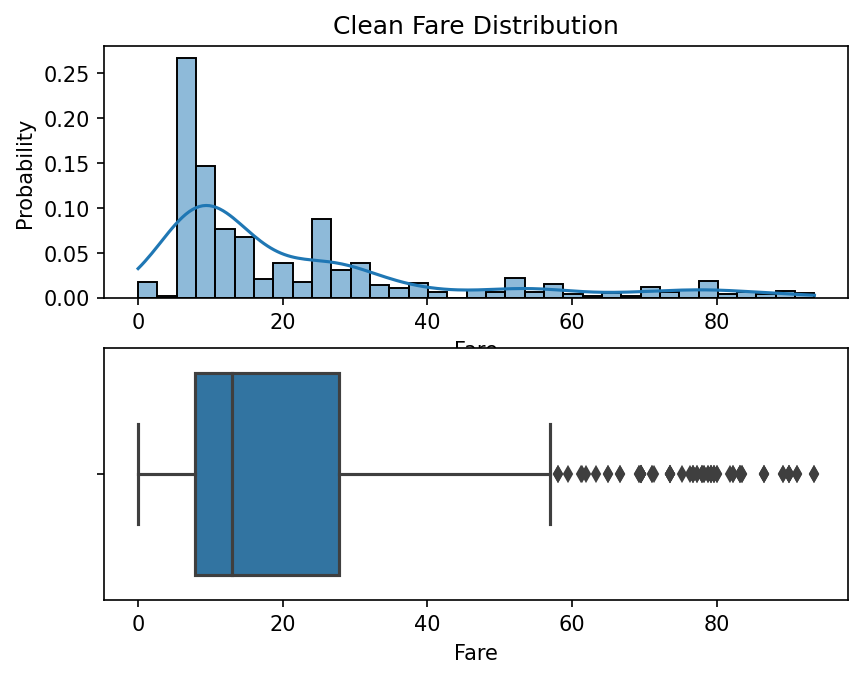

In [283]:
fig, axes = plt.subplots(2,1)

sns.histplot(data=df, x="Fare", kde=True, stat="probability", bins=35, ax = axes[0])
axes[0].set_title("Clean Fare Distribution")

sns.boxplot(data=df, x="Fare", ax=axes[1])

plt.show()

### Age

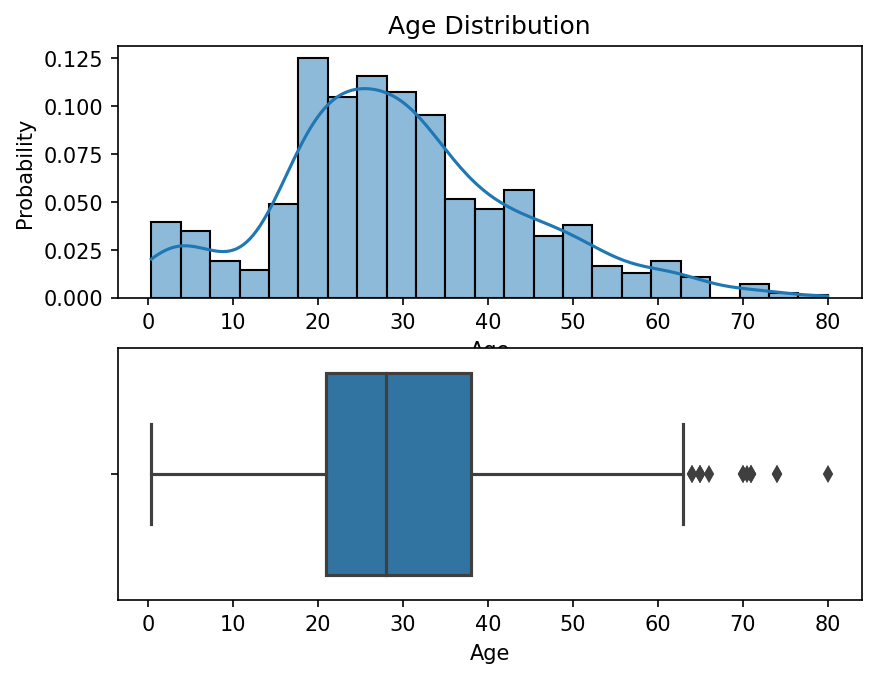

In [284]:
fig, axes = plt.subplots(2,1)

sns.histplot(data=df, x="Age", kde=True, stat="probability", ax = axes[0])
axes[0].set_title("Age Distribution")

sns.boxplot(data=df, x="Age", ax=axes[1])

plt.show()

In [285]:
df["Age"] = remove_outliers(df.Age, 1.5)
print(df.Age.notna().sum())
df.dropna(inplace=True)

Límite de datos atípicos: 63.5
823


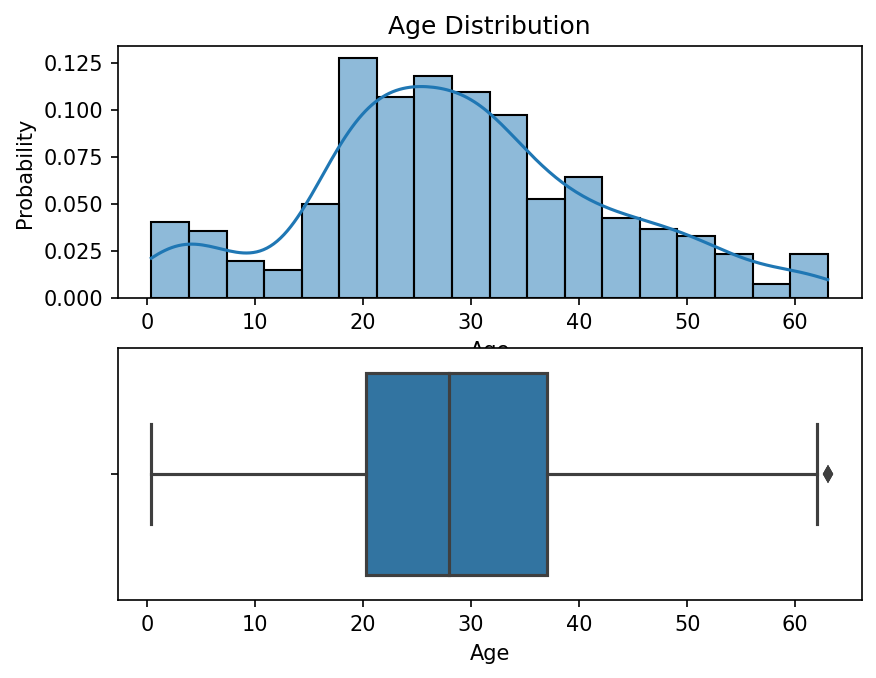

In [286]:
fig, axes = plt.subplots(2,1)

sns.histplot(data=df, x="Age", kde=True, stat="probability", ax = axes[0])
axes[0].set_title("Age Distribution")

sns.boxplot(data=df, x="Age", ax=axes[1])

plt.show()

### Survived

In [287]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


In [288]:
df.Survived.value_counts()

0    521
1    302
Name: Survived, dtype: int64

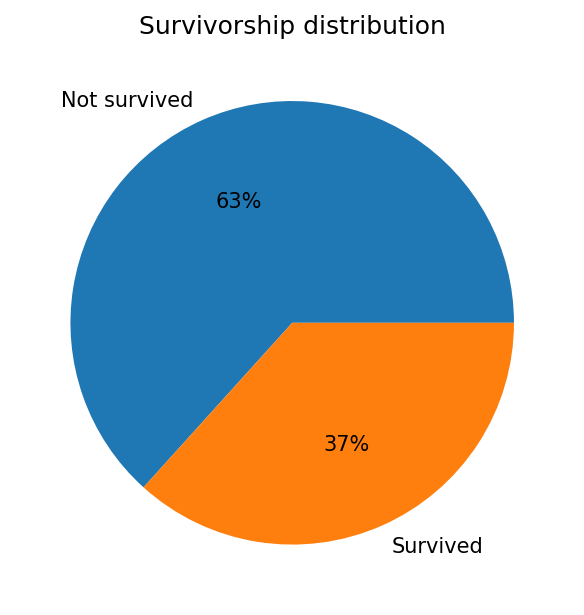

In [289]:
fig, ax = plt.subplots()
ax.pie(df.Survived.value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
ax.set_title("Survivorship distribution")
plt.show()

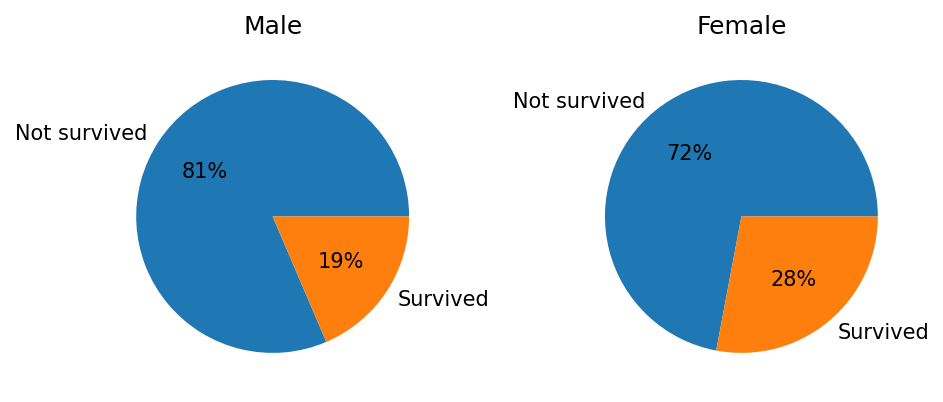

In [290]:
fig, axes = plt.subplots(1,2)

axes[0].pie(df.Survived.where(df.Sex == "male").value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[0].set_title("Male")

axes[1].pie(df.Survived.where(df.Sex == "female").value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[1].set_title("Female")

plt.tight_layout()
plt.show()

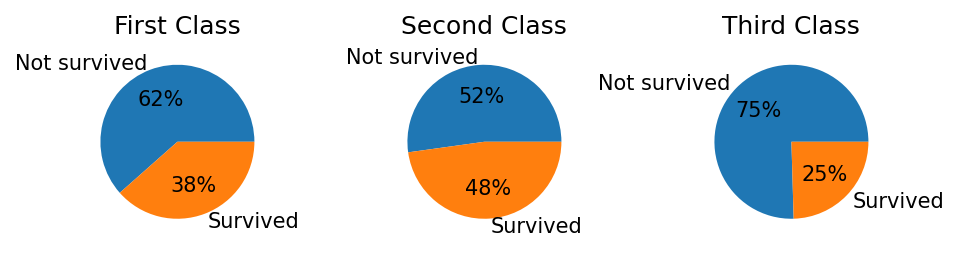

In [291]:
fig, axes = plt.subplots(1,3)

axes[0].pie(df.Survived.where(df.Pclass == 1).value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[0].set_title("First Class")

axes[1].pie(df.Survived.where(df.Pclass == 2).value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[1].set_title("Second Class")

axes[2].pie(df.Survived.where(df.Pclass == 3).value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[2].set_title("Third Class")


plt.tight_layout()
plt.show()

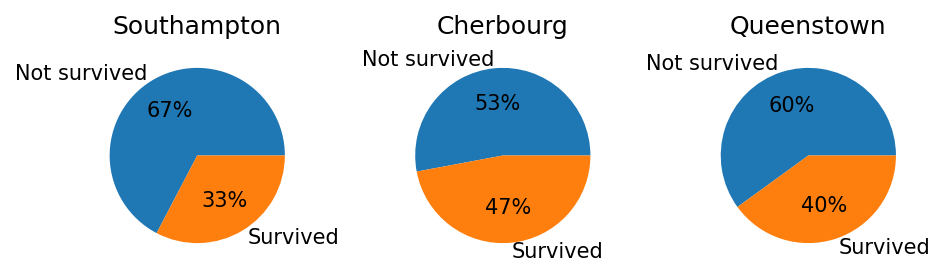

In [292]:
fig, axes = plt.subplots(1,3)

axes[0].pie(df.Survived.where(df.Embarked == "S").value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[0].set_title("Southampton")

axes[1].pie(df.Survived.where(df.Embarked == "C").value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[1].set_title("Cherbourg")

axes[2].pie(df.Survived.where(df.Embarked == "Q").value_counts(), labels=["Not survived", "Survived"], autopct="%.0f%%")
axes[2].set_title("Queenstown")


plt.tight_layout()
plt.show()

In [293]:
# Discrete seaborn heatmap to plot variation in survivorship based on class?

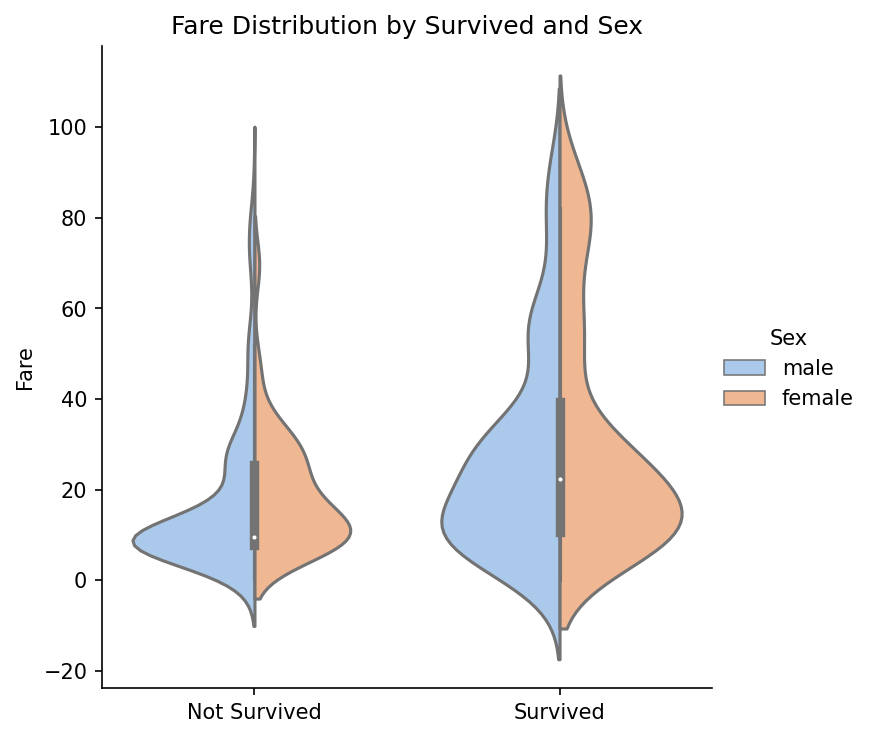

In [294]:
sns.catplot(data=df, x="Survived", y="Fare", hue="Sex", kind="violin", split=True, palette="pastel")
plt.title("Fare Distribution by Survived and Sex")
plt.xticks([0, 1], ["Not Survived", "Survived"])
plt.xlabel("")
plt.show()

In [295]:
print("Survived Fare mean:", df.Fare.where(df.Survived == 1).mean())
print("Not survived Fare mean:", df.Fare.where(df.Survived == 0).mean())

Survived Fare mean: 30.04798675496688
Not survived Fare mean: 17.778509021113248


In [296]:
print("Survived Fare median:", df.Fare.where(df.Survived == 1).median())
print("Not survived Fare median:", df.Fare.where(df.Survived == 0).median())

Survived Fare median: 22.3583
Not survived Fare median: 9.5


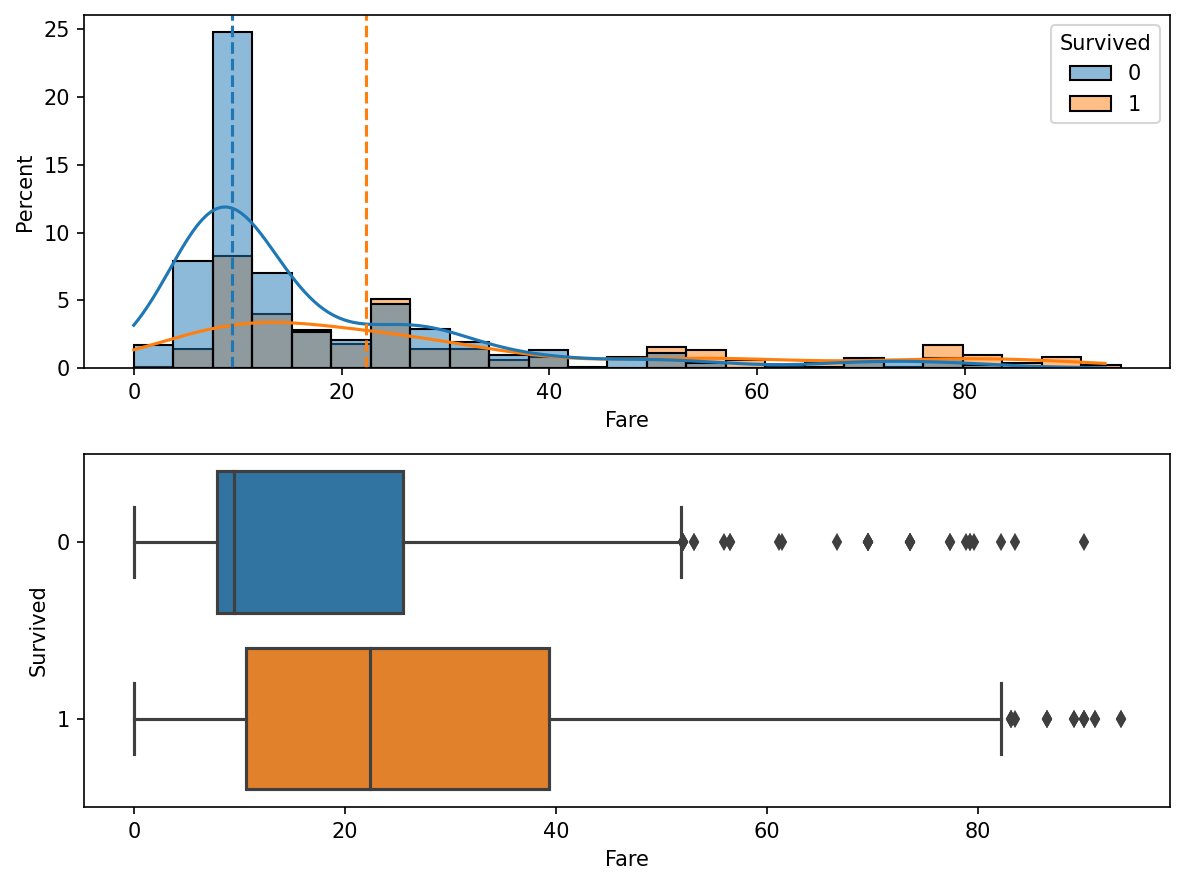

In [297]:
fig, axes = plt.subplots(2,1, figsize=(8,6))

sns.histplot(data=df, x="Fare", hue="Survived", kde=True, stat="percent", binwidth=3.8, ax=axes[0])
axes[0].axvline(df.Fare.where(df.Survived == 1).median(), c="tab:orange", linestyle="--")
axes[0].axvline(df.Fare.where(df.Survived == 0).median(), c="tab:blue", linestyle="--")

sns.boxplot(data=df, x="Fare", y="Survived", orient="h", ax=axes[1])

plt.tight_layout()
plt.show()

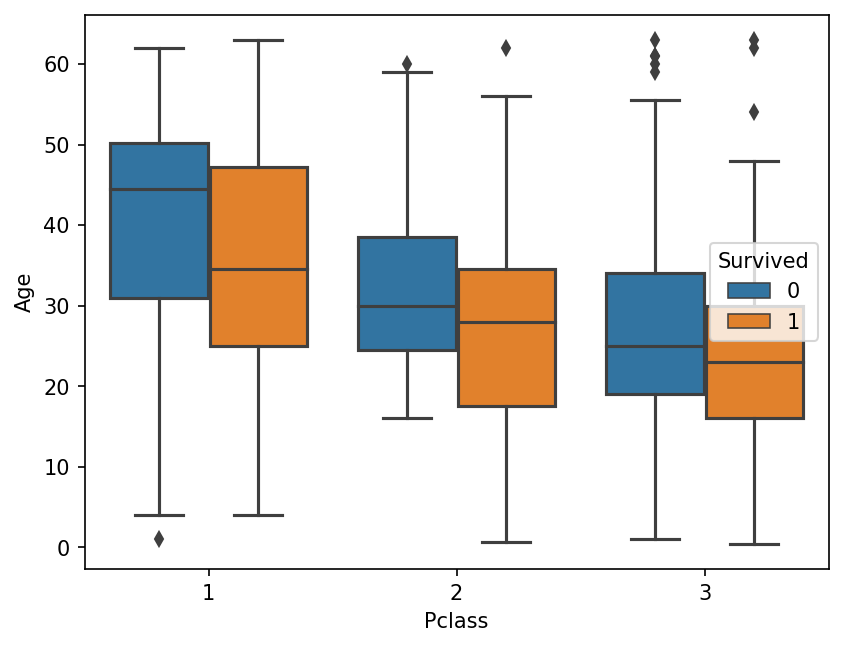

In [298]:
sns.boxplot(data=df, x="Pclass", y="Age", hue="Survived")
plt.show()

In [299]:
survived = df.groupby("Survived").get_group(1)

# Feature Engineering

In [300]:
def data_pipeline(dataframe):
    age_sample = dataframe.Age[dataframe.Age.notna()].sample(dataframe.Age.isna().sum())
    dataframe.Age.fillna(pd.Series(age_sample.to_list(), index=dataframe.Age[dataframe.Age.isna()].index), inplace=True)
    dataframe["Sex"] = pd.get_dummies(dataframe.Sex)["female"]      # Turn sex into one-hot, 1 is female, 0 is male
    dataframe[["Class1", "Class2", "Class3"]] = pd.get_dummies(dataframe.Pclass)    # Ticket Class to dummy variables
    dataframe[["Cherbourg", "Queenstown", "Southampton"]] = pd.get_dummies(dataframe.Embarked)      # Embarked to dummy variables
    alone = (dataframe.SibSp < 1) & (dataframe.Parch < 1)       # Generate Lone traveler variable
    dataframe["Alone"] = alone.astype(int)
    # Transform Cabin column to a Deck dummy variables; obtain which Deck the cabin was in
    dataframe.Cabin.fillna("U", inplace=True)
    decks = ["A", "B", "C", "D", "E", "U"]
    for deck in decks:
        titanic_class = dataframe.Cabin.str.contains(deck).astype(int)
        dataframe["Deck_" + deck] = titanic_class
    dataframe.drop(columns=["Pclass", "Name", "Ticket", "Cabin", "Embarked", "PassengerId"], inplace=True)
    return dataframe

In [301]:
df = data_pipeline(df)

C:\Users\Cris\AppData\Local\Temp\ipykernel_15148\2368694357.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dataframe.Age.fillna(pd.Series(age_sample.to_list(), index=dataframe.Age[dataframe.Age.isna()].index), inplace=True)


In [302]:
# Feature extraction idea: family divisions? Lone travelers?
# df[df.Name.str.contains("Palsson")]
# df[(df.SibSp < 2) & (df.Parch > 2)]

# Travel alone category
# Parent, number of children
# Child, number of siblings

In [303]:
df.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Class1,Class2,Class3,Cherbourg,Queenstown,Southampton,Alone,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_U
0,0,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0,1,0,0,0,0,0,1,0,0,0
2,1,1,26.0,0,0,7.9250,0,0,1,0,0,1,1,0,0,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,1,0,0,0
4,0,0,35.0,0,0,8.0500,0,0,1,0,0,1,1,0,0,0,0,0,1


## Variable Correlation

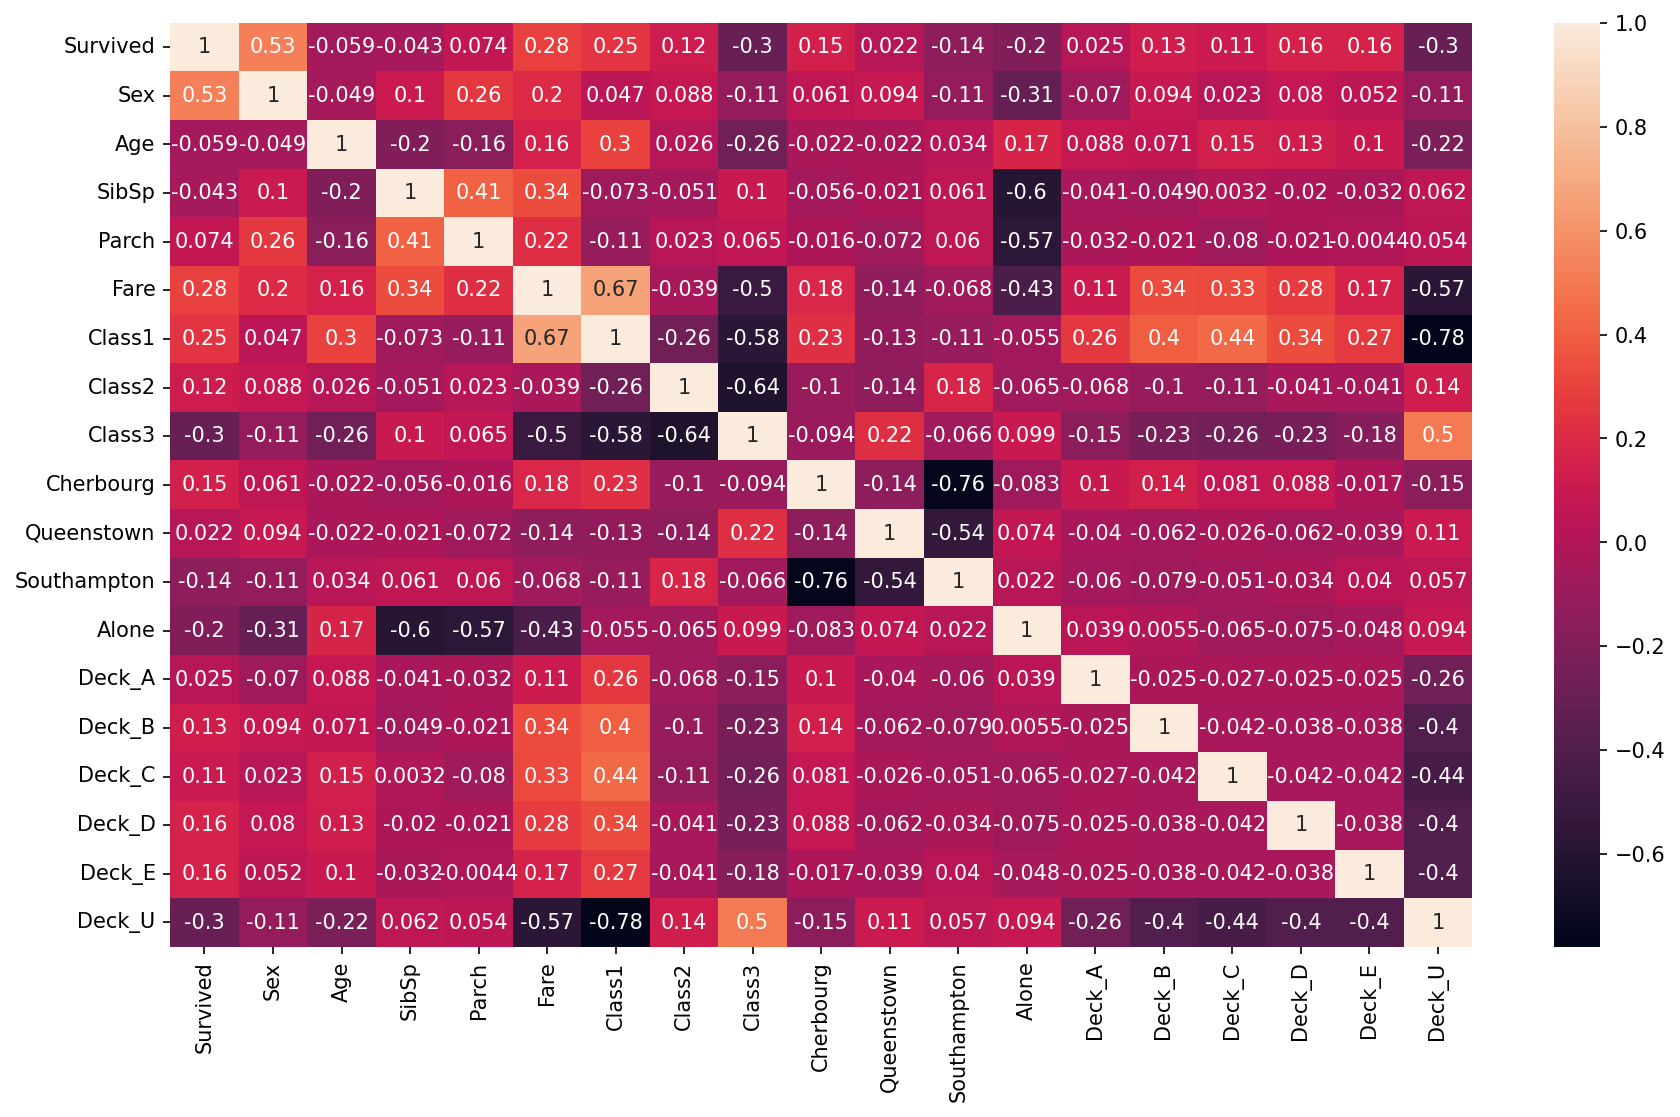

In [304]:
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

# Train Test Split

Since the data is already split for us, there is no need to use a data-splitting function from a library (or even do it ourselves manually, hehe). Instead, we're going to create a partition of our *df* dataset as training data, and load the test dataset to have them both ready for our Machine Learning Model.

In [330]:
x_train = df.drop(columns=["Survived"])
y_train = df.Survived
x_train.head()

,Sex,Age,SibSp,Parch,Fare,Class1,Class2,Class3,Cherbourg,Queenstown,Southampton,Alone,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_U
0,0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,0,0,0,0,1,0,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,0,1,1,0,0,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,1,1,0,0,0,0,0,1


In [331]:
from sklearn.model_selection import train_test_split

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, train_size=0.7)

In [332]:
test = pd.read_csv("titanic_test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [333]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We pass this data frame through our data pipeline so we have homogeneous datasets

In [334]:
test = data_pipeline(test)
test.head()

,Sex,Age,SibSp,Parch,Fare,Class1,Class2,Class3,Cherbourg,Queenstown,Southampton,Alone,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_U
0,0,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,0,0,0,1
1,1,47.0,1,0,7.0000,0,0,1,0,0,1,0,0,0,0,0,0,1
2,0,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,0,0,1
3,0,27.0,0,0,8.6625,0,0,1,0,0,1,1,0,0,0,0,0,1
4,1,22.0,1,1,12.2875,0,0,1,0,0,1,0,0,0,0,0,0,1


# Machine Learning Model

In [335]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [367]:
rs = 0
model = RandomForestClassifier(max_depth=50, random_state=rs)
# model = MLPClassifier(random_state=rs, solver="adam", max_iter=500)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=50, random_state=0)

In [368]:
print("Train score: ", round(model.score(x_train, y_train), 4))
print("Validate score: ", round(model.score(x_validate, y_validate), 4))

Train score:  0.9913
Validate score:  0.8016


In [369]:
from sklearn.metrics import classification_report, confusion_matrix

In [370]:
print(classification_report(y_train, model.predict(x_train), target_names=["Not survived", "Survived"]))

              precision    recall  f1-score   support

Not survived       0.99      1.00      0.99       373
    Survived       1.00      0.98      0.99       203

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



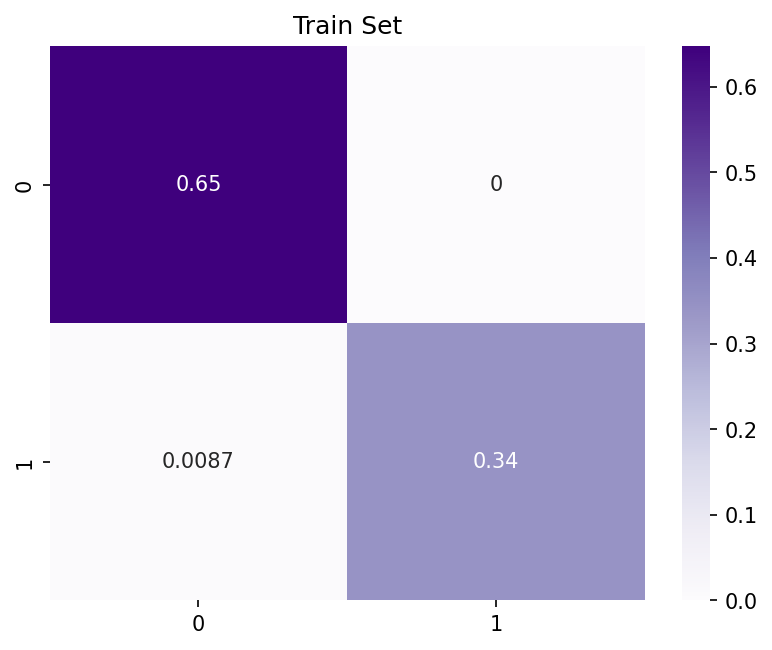

In [371]:
sns.heatmap(confusion_matrix(y_train, model.predict(x_train), normalize="all"), annot=True, cmap="Purples")
plt.title("Train Set")
plt.show()

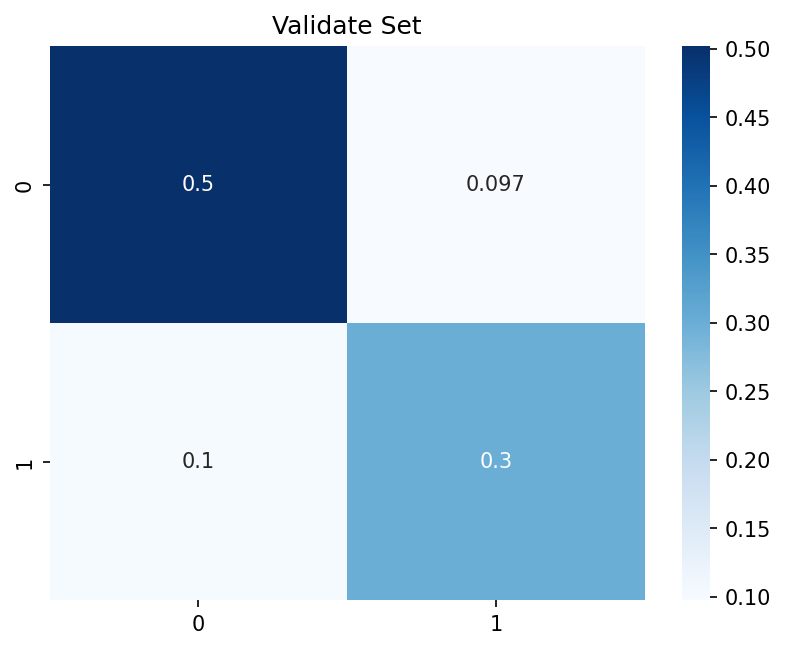

In [372]:
sns.heatmap(confusion_matrix(y_validate, model.predict(x_validate), normalize="all"), annot=True, cmap="Blues")
plt.title("Validate Set")
plt.show()